# age estimation

In [34]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils import data
from torchvision.models import mobilenet_v2, resnet34, resnet50
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output
%matplotlib inline

In [35]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 0
np.random.seed(0)
PATH = 'C:\\Users\\usr\\Documents\\GitHub\\dl\\2-UTKFace'
LOGFILE = os.path.join(PATH, 'training.log')
DATASET_PATH = os.path.join('W:', os.sep, 'datasets', 'UTKFace')

print('DEVICE ', DEVICE)
print('RANDOM SEED ', RANDOM_SEED)
print('PATH ', PATH)
print('LOGFILE ', LOGFILE)

DEVICE  cuda:0
RANDOM SEED  0
PATH  C:\Users\usr\Documents\GitHub\dl\2-UTKFace
LOGFILE  C:\Users\usr\Documents\GitHub\dl\2-UTKFace\training.log


In [36]:
NUM_CLASSES = 6
BATCH_SIZE = 8

In [37]:
T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(), # [0,255] -> [0.0, 1.0]
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # below zero 
    
])

In [38]:
class UTKFaceDataset(data.Dataset):

    def __init__(self, path, subset = 'train', test_part = 0.2, transform = None):
        'Initialization'
        self.path = path
        self.subset = subset
        self.transform = transform
        names = [it for it in os.listdir(path) if len(it.split('_')) > 3]
        names = [os.path.join(path, it) for it in names]
        #np.random.seed(0)
        np.random.shuffle(names)
        if subset == 'train':
            self.ids = names[:int(len(names) * test_part)]
        elif subset == 'valid':
            self.ids = names[int(len(names) * test_part):]
        self.age_list = [(0, 5), (5,14), (14, 30), (30, 45), (45, 60), (60, 120)]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ids)
    

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.ids[index]

        image = Image.open(ID)

        # Load data and get label
        age = int(ID.split('\\')[-1].split('_')[0])
        group_age = age
        for i in range(6):
            group = range(self.age_list[i][0], self.age_list[i][1])
            if age in group:
                group_age = i

        if self.transform:
            image = self.transform(image)
        
        return image, age, group_age

In [39]:
train_data = UTKFaceDataset(DATASET_PATH, subset='train', test_part = 0.8, transform = T) #0.2
valid_data = UTKFaceDataset(DATASET_PATH, subset='valid', test_part = 0.8, transform = T)

print('train data len: ', train_data.__len__())
print('valid data len: ', valid_data.__len__())

train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

# download and transform test dataset
valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False)

train data len:  18964
valid data len:  4741


40 3


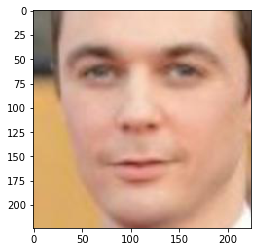

In [40]:
img, age, group_age = train_data[138]
print(age, group_age)
plt.imshow(img.numpy().transpose(1,2,0));

age:     tensor([22, 26, 32, 26,  4, 12, 50, 50])
group age:     tensor([2, 2, 3, 2, 0, 1, 4, 4])


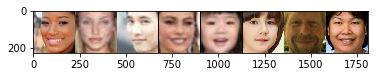

In [41]:
images, age, group_age = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))
print("age:    ", age)
print("group age:    ", group_age)

In [42]:
class Net(nn.Module): #Multi-task learning
    def __init__(self, net='resnet34', pretrained=True):
        super(Net, self).__init__()
        self.net = net

        if self.net == 'resnet34':
            self.model = models.resnet34(pretrained=True)
            self.model.fc = nn.Linear(512, NUM_CLASSES)
            #self.model.age_reg = nn.Linear(512, 1)
            #self.age_list = [(0, 5), (5,14), (14, 30), (30, 45), (45, 60), (60, 120)]
        

    def forward(self, x):
        if self.net == 'resnet34':
            x = self.model.conv1(x)
            x = self.model.bn1(x)
            x = self.model.relu(x)
            x = self.model.maxpool(x)
            x = self.model.layer1(x)
            x = self.model.layer2(x)
            x = self.model.layer3(x)
            x = self.model.layer4(x)
            x = self.model.avgpool(x)
            x = x.view(x.size(0), -1)

            logits = self.model.fc(x)
            probas = F.softmax(logits, dim=1)
        return logits, probas
    


In [43]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
model = Net(net='resnet34').to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [44]:
#def compute_mae_and_mse(model, data_loader, device):
#    mae, mse, num_examples = 0, 0, 0
#    for i, (features, targets) in enumerate(data_loader):
#        features = features.to(device)
#        targets = targets.to(device)
#        
#        logits, probas = model(features)
#        _, predicted_labels = torch.max(probas, 1)
#        num_examples += targets.size(0)
#        mae += torch.sum(torch.abs(predicted_labels - targets))
#        mse += torch.sum((predicted_labels - targets)**2)
#    mae = mae.float()/num_examples
#    mse = mse.float()/num_examples
#    #print("num ", num_examples)
#    return mae, mse

In [45]:
print("BATCH_SIZE ", BATCH_SIZE)
print("---train--")
print("num_batches ", len(train_loader))
print("full batches ", len(train_loader.dataset)//BATCH_SIZE)
print("num images ", len(train_loader.dataset))
print("--valid--")
print("num_batches ", len(valid_loader))
print("full batches ", len(valid_loader.dataset)//BATCH_SIZE)
print("num images ", len(valid_loader.dataset))

BATCH_SIZE  8
---train--
num_batches  2371
full batches  2370
num images  18964
--valid--
num_batches  593
full batches  592
num images  4741


~~~
targets.size() -> torch.Size([8])
targets.size(0) = 8 (or less)
num_examples = num_batches * 8
num_examples =  len(train_loader.dataset))

featires size  torch.Size([8, 3, 224, 224])
targets size  torch.Size([8])
targets2 size  torch.Size([8])
logits size  torch.Size([8, 6])
probas size  torch.Size([8, 6])

~~~

In [46]:
%%time
epochs = 10
x = list(range(1, epochs + 1))

train_cost_list = []
valid_cost_list = []
train_mae_list = []
valid_mae_list = []
train_rmse_list = []
valid_rmse_list = []

print("epoch|loss |val_loss|train MAE/RMSE  |val MAE/RMSE  |")
for epoch in range(epochs):  # loop over the dataset multiple times
    for phase in ['train', 'valid']:
        
        if phase == 'train':
            model.train(True)
            num_examples = 0#len(train_loader.dataset)
            mae, mse,  running_loss, cost = 0, 0, 0, 0
            for batch_idx, (features, targets, targets2) in enumerate(train_loader):

                features = features.to(DEVICE)
                targets = targets.to(DEVICE)
                targets = targets.float()
                targets2 = targets2.to(DEVICE)

                optimizer.zero_grad()

                logits, probas = model(features)

                _, predicted_labels = torch.max(probas, 1)
                means = torch.tensor([[2, 9, 21.5, 37, 52, 89.5],]* targets.size(0))
                means = means.to(DEVICE)
                p = torch.mul(probas, means)
                p = torch.sum(p, dim=1)
                num_examples += targets.size(0)

                #mae += torch.sum(torch.abs(predicted_labels - targets))
                mae += torch.sum(torch.abs(p - targets))


                #mse += torch.sum((predicted_labels - targets)**2)
                mse += torch.sum((p - targets)**2)

                
                #loss = criterion(logits, targets)

                loss = criterion(logits, targets2)

                loss.backward()
                optimizer.step()      
                running_loss += loss.item() #* features.size(0)

            mae = mae.float()/num_examples
            mse = mse.float()/num_examples 
            running_loss /= len(train_loader)
            rmse = torch.sqrt(mse)

        elif phase == 'valid':
            with torch.no_grad():
                model.train(False)
                v_num_examples = 0#len(valid_loader.dataset)
                v_mae, v_mse,  v_running_loss, v_cost = 0, 0, 0, 0

                for v_batch_idx, (v_features, v_targets, v_targets2) in enumerate(valid_loader):
                    #print(v_batch_idx, v_targets.size(0))
                    #v_cost = 0
                    v_features = v_features.to(DEVICE)
                    v_targets = v_targets.to(DEVICE)
                    v_targets = v_targets.float()
                    v_targets2 = v_targets2.to(DEVICE)

                    v_logits, v_probas = model(v_features)
                    _, v_predicted_labels = torch.max(v_probas, 1)
                    v_means = torch.tensor([[2, 9, 21.5, 37, 52, 89.5],]* v_targets.size(0))
                    v_means = v_means.to(DEVICE)

                    v_p = torch.mul(v_probas, v_means)
                    v_p = torch.sum(v_p, dim=1)

                    v_num_examples += v_targets.size(0) # + total images in each batch
                    #print(v_num_examples)
                    #v_mae += torch.sum(torch.abs(predicted_labels - targets))
                    #v_mse += torch.sum((predicted_labels - targets)**2)
                    v_mae += torch.sum(torch.abs(v_p - v_targets))
                    v_mse += torch.sum((v_p - v_targets)**2)
                    v_loss = criterion(v_logits, v_targets2)
                    v_running_loss += v_loss.item() #* features.size(0)
                
#.item()
                v_mae = v_mae.float()/v_num_examples
                v_mse = v_mse.float()/v_num_examples
                v_running_loss /= len(valid_loader)#v_num_examples # = epoch loss
            
                v_rmse = torch.sqrt(v_mse)



                

    print('%5d|%4.3f| %4.3f  |   %6.3f/%6.3f| %6.3f/%6.3f|' %
          (epoch + 1, 
           running_loss, v_running_loss,
           mae, rmse,
           v_mae, v_rmse
          ))           
    
    train_cost_list.append(running_loss)
    valid_cost_list.append(v_running_loss)
    train_mae_list.append(mae.item())
    valid_mae_list.append(v_mae.item())
    train_rmse_list.append(rmse.item())
    valid_rmse_list.append(v_rmse.item())
    

         
print('Finished Training')

epoch|loss |val_loss|train MAE/RMSE  |val MAE/RMSE  |
    1|1.051| 0.779  |    8.474/11.882|  6.739/10.056|
    2|0.818| 0.631  |    6.762/ 9.596|  6.518/ 9.364|
    3|0.693| 0.523  |    6.213/ 8.900|  5.535/ 8.229|
    4|0.605| 0.508  |    5.888/ 8.474|  4.647/ 6.592|
    5|0.514| 0.428  |    5.720/ 8.379|  5.279/ 7.604|
    6|0.445| 0.365  |    5.616/ 8.267|  5.445/ 8.130|
    7|0.373| 0.344  |    5.514/ 8.181|  5.674/ 8.361|
    8|0.302| 0.319  |    5.411/ 8.083|  5.488/ 8.265|
    9|0.249| 0.363  |    5.342/ 7.994|  6.218/ 9.491|
   10|0.212| 0.465  |    5.298/ 8.003|  5.968/ 8.703|
Finished Training
Wall time: 39min 28s


In [27]:
#print(torch.cuda.max_memory_allocated())
#print(torch.cuda.max_memory_cached())
#print(torch.cuda.memory_allocated())
#print(torch.cuda.memory_cached())

6516075008
6673137664
6515664896
6673137664


In [53]:
#torch.cuda.memory_stats(device=DEVICEVICE)

In [25]:
# Checks model's parameters
#print(model.state_dict())

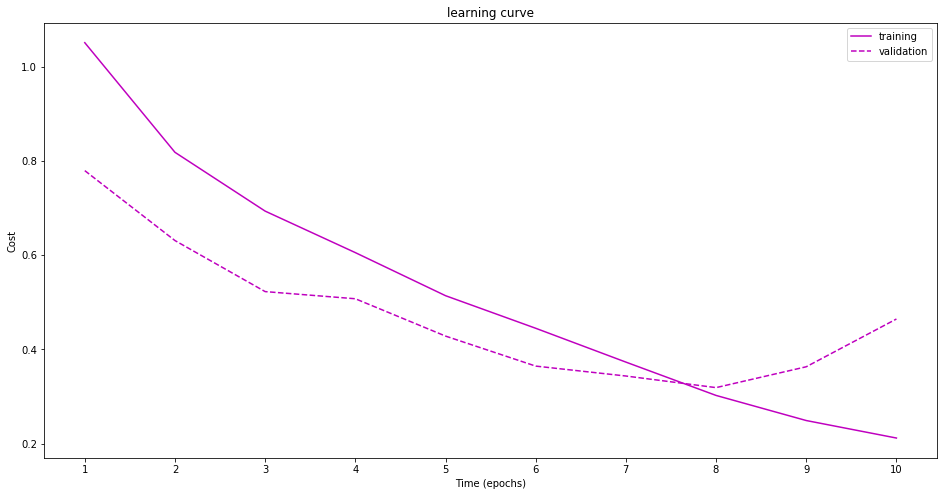

In [51]:
plt.figure(figsize=(16,8))
plt.title("learning curve")
plt.plot(x, train_cost_list,'m',  label= 'training')
plt.plot(x, valid_cost_list,'m--', label= 'validation')
plt.xlabel("Time (epochs)")
plt.ylabel("Cost")
plt.xticks(range(1, 11))
plt.legend();

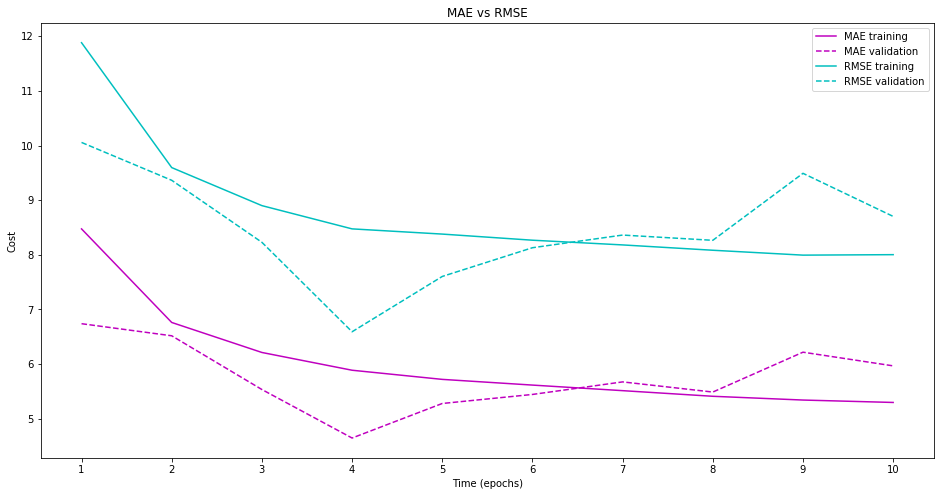

In [50]:
plt.figure(figsize=(16,8))
plt.title("MAE vs RMSE")
plt.plot(x, train_mae_list,'m', label= 'MAE training')
plt.plot(x, valid_mae_list,'m--', label= 'MAE validation')
plt.plot(x, train_rmse_list,'c', label= 'RMSE training')
plt.plot(x, valid_rmse_list, 'c--', label= 'RMSE validation')
plt.xlabel("Time (epochs)")
plt.ylabel("Cost")
plt.xticks(range(1, 11))
plt.legend();

- age_1.csv - ResNet34
~~~
epoch|loss |val_loss|train MAE/RMSE  |val MAE/RMSE  |
    1|1.051| 0.779  |    8.474/11.882|  6.739/10.056|
    2|0.818| 0.631  |    6.762/ 9.596|  6.518/ 9.364|
    3|0.693| 0.523  |    6.213/ 8.900|  5.535/ 8.229|
    4|0.605| 0.508  |    5.888/ 8.474|  4.647/ 6.592|
    5|0.514| 0.428  |    5.720/ 8.379|  5.279/ 7.604|
    6|0.445| 0.365  |    5.616/ 8.267|  5.445/ 8.130|
    7|0.373| 0.344  |    5.514/ 8.181|  5.674/ 8.361|
    8|0.302| 0.319  |    5.411/ 8.083|  5.488/ 8.265|
    9|0.249| 0.363  |    5.342/ 7.994|  6.218/ 9.491|
   10|0.212| 0.465  |    5.298/ 8.003|  5.968/ 8.703|
Finished Training
Wall time: 39min 28s
~~~


In [54]:
#path = 'C:\\Users\\usr\\Documents\\GitHub\\dl\\2-UTKFace'
#LOGFILE = os.path.join(path, 'training.log')

In [55]:
df = pd.DataFrame()
df['training loss'] = train_cost_list
df['validation loss'] = valid_cost_list
df['training mae'] = train_mae_list
df['validation mae'] = valid_mae_list
df['training rmse'] = train_rmse_list
df['validation rmse'] = valid_rmse_list



path = 'C:\\Users\\usr\\Documents\\GitHub\\dl\\2-UTKFace\\age_1.csv'
df.to_csv(path, index=False)
pd.read_csv('age_1.csv')

,training loss,validation loss,training mae,validation mae,training rmse,validation rmse
0,1.050705,0.779288,8.474084,6.739294,11.881626,10.056247
1,0.818156,0.630962,6.761838,6.518099,9.596048,9.363586
2,0.693419,0.522692,6.212760,5.534778,8.899987,8.228714
3,0.605397,0.507522,5.887650,4.646994,8.474430,6.591647
4,0.514040,0.428352,5.720366,5.279230,8.379114,7.603856
5,0.444912,0.364666,5.615945,5.444535,8.267125,8.129527
6,0.373155,0.343626,5.513907,5.674236,8.180882,8.361201
7,0.302442,0.319014,5.410985,5.488329,8.083345,8.265195
8,0.249195,0.363242,5.342106,6.217910,7.993923,9.490948
9,0.212069,0.464553,5.298036,5.967546,8.002597,8.702608


predicted 86 gt 60
predicted 36 gt 30
predicted 21 gt 26
predicted 34 gt 33
predicted 21 gt 39
predicted 89 gt 78
predicted 21 gt 22
predicted 48 gt 50


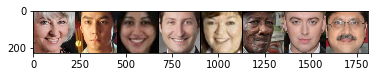

In [74]:
data = next(iter(valid_loader))
images, age ,age2= data[0].to(DEVICE), data[1].to(DEVICE), data[2].to(DEVICE)

logits, probas = model(images)#.view(-1)
#print("logits \n", logits.cpu().detach().numpy())
#print("probas \n", probas.cpu().detach().numpy())
_, predicted_labels = torch.max(probas, 1)

means = torch.tensor([2, 9, 21.5, 37, 52, 89.5])
means = means.to(DEVICE)
p = torch.mul(probas, means)
p = torch.sum(p, dim=1)

age_class = predicted_labels.cpu().detach().numpy()
age_years = p.cpu().detach().numpy()
age_gt = age.cpu().detach().numpy()
for i in range(BATCH_SIZE):
    print("predicted %d gt %d"%(age_years[i], age_gt[i]))
#print("predicted class \n", predicted_labels.cpu().detach().numpy())
#print("predicted age \n", p.cpu().detach().numpy())
#print("gt \n", age.cpu().detach().numpy())
# gt|predicted
plt.imshow(torchvision.utils.make_grid(images).cpu().detach().numpy().transpose(1,2,0));

In [75]:
#p = probas.cpu().detach().numpy()[3]
#sum(p) # = 1

In [76]:
#age_list = [(0, 5), (5,14), (14, 30), (30, 45), (45, 60), (60, 120)]
# np.mean(range(60,120))
#means = [2, 9, 21.5, 37, 52, 89.5]

In [77]:
#np.sum(p*means)